# Visualizations Notebook

## Prepare Data

In [ ]:
!pip install pyspark
!pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b8cd0646fa8cb8b1ffb1690d397f0e6726200f94f7ccf2d6eddb6bf31e940ae9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import opendatasets as od
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt

od.download("https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data")

In [ ]:
df = pd.read_csv("/content/vehicle-sales-data/car_prices.csv")
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
df.shape

(558837, 16)

### Handling Missing Values

In [ ]:
missing_values = df.isnull().sum()
total_values = df.shape[0]
percentage_missing = (missing_values / total_values) * 100
columns_with_missing = missing_values[missing_values > 0]

missing_data_table = []
for col in columns_with_missing.index:
    missing_data_table.append([col, missing_values[col], f"{percentage_missing[col]:.2f}%"])

print(tabulate(missing_data_table, headers=['Column', 'Missing Values', 'Percentage']))


Column          Missing Values  Percentage
------------  ----------------  ------------
make                     10301  1.84%
model                    10399  1.86%
trim                     10651  1.91%
body                     13195  2.36%
transmission             65352  11.69%
vin                          4  0.00%
condition                11820  2.12%
odometer                    94  0.02%
color                      749  0.13%
interior                   749  0.13%
mmr                         38  0.01%
sellingprice                12  0.00%
saledate                    12  0.00%


In [ ]:
# Drop rows with missing values for all columns except 'transmission'
df_cleaned = df.copy()
cols_to_check = ['make', 'model', 'trim', 'body', 'vin', 'condition', 'odometer', 'color', 'interior', 'mmr', 'sellingprice', 'saledate']
df_cleaned.dropna(subset=cols_to_check, inplace=True)

# Check if there are any remaining missing values
missing_values_after_drop = df_cleaned.isnull().sum()
print("Remaining missing values after dropping rows:")
print(missing_values_after_drop[missing_values_after_drop > 0])


Remaining missing values after dropping rows:
transmission    61323
dtype: int64


### KNN Imputation

In [ ]:
# KNN imputation for transmission with K = 5

df_imputed = df_cleaned.copy()
encoder = OrdinalEncoder()
df_imputed[['transmission']] = encoder.fit_transform(df_imputed[['transmission']])

imputer = KNNImputer(n_neighbors=5)
transmission_col = 'transmission'
transmission_imputed = imputer.fit_transform(df_imputed[[transmission_col]])
df_imputed[transmission_col] = transmission_imputed

# Decode 'transmission' column back to original values
df_imputed[['transmission']] = encoder.inverse_transform(df_imputed[['transmission']])

missing_values_after_imputation = df_imputed.isnull().sum()
print("Remaining missing values after imputation:")
print(missing_values_after_imputation[missing_values_after_imputation > 0])

Remaining missing values after imputation:
Series([], dtype: int64)


In [ ]:
df_imputed.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [ ]:
df_imputed.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


### VIF

In [ ]:
X = df_imputed[['condition','odometer', 'mmr','year']]
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

     feature            VIF
0      const  757078.570699
1  condition       1.142409
2   odometer       2.678808
3        mmr       1.640731
4       year       2.742400


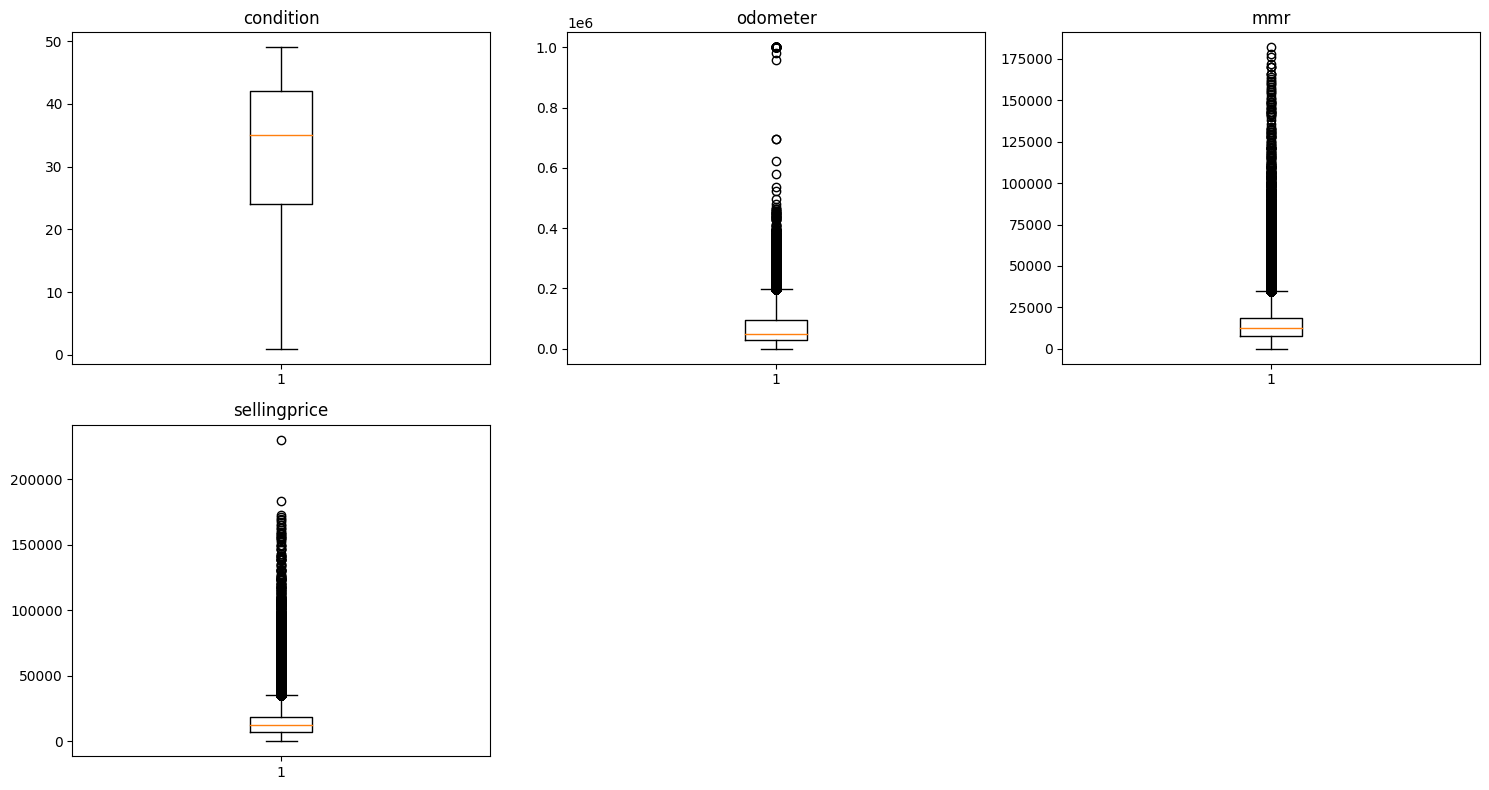

In [ ]:
columns_to_plot = ['condition', 'odometer', 'mmr', 'sellingprice']
plt.figure(figsize=(15, 8))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df_imputed[col].dropna())
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
df_imputed.shape

(533648, 16)

In [ ]:
df_imputed.to_csv('/content/drive/MyDrive/23 24/Spring 24/Big Data/Big Data Project/impdf.csv', index=False)

## Visualizations

In [44]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df= pd.read_csv('/content/drive/MyDrive/23 24/Spring 24/Big Data/Big Data Project/impdf.csv')
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533648 entries, 0 to 533647
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          533648 non-null  int64  
 1   make          533648 non-null  object 
 2   model         533648 non-null  object 
 3   trim          533648 non-null  object 
 4   body          533648 non-null  object 
 5   transmission  533648 non-null  object 
 6   vin           533648 non-null  object 
 7   state         533648 non-null  object 
 8   condition     533648 non-null  float64
 9   odometer      533648 non-null  float64
 10  color         533648 non-null  object 
 11  interior      533648 non-null  object 
 12  seller        533648 non-null  object 
 13  mmr           533648 non-null  float64
 14  sellingprice  533648 non-null  float64
 15  saledate      533648 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 65.1+ MB


In [5]:
df.nunique()

year                26
make                53
model              772
trim              1510
body                86
transmission         2
vin             525638
state               38
condition           41
odometer        166557
color               20
interior            17
seller           12735
mmr               1101
sellingprice      1852
saledate          3687
dtype: int64

In [6]:
df['body'].value_counts()

body
Sedan          194608
SUV            115997
sedan           41826
suv             24534
Hatchback       20883
                ...  
cab plus 4          1
g37 coupe           1
Ram Van             1
CTS-V Wagon         1
cts wagon           1
Name: count, Length: 86, dtype: int64

In [7]:
df['body'].unique()

array(['SUV', 'Sedan', 'Convertible', 'Coupe', 'Wagon', 'Hatchback',
       'Crew Cab', 'G Coupe', 'G Sedan', 'Elantra Coupe', 'Genesis Coupe',
       'Minivan', 'Van', 'Double Cab', 'CrewMax Cab', 'Access Cab',
       'King Cab', 'SuperCrew', 'CTS Coupe', 'Extended Cab',
       'E-Series Van', 'SuperCab', 'Regular Cab', 'G Convertible', 'Koup',
       'Quad Cab', 'CTS-V Coupe', 'sedan', 'G37 Convertible', 'Club Cab',
       'Xtracab', 'Q60 Convertible', 'CTS Wagon', 'G37 Coupe', 'Mega Cab',
       'Cab Plus 4', 'Q60 Coupe', 'Beetle Convertible', 'TSX Sport Wagon',
       'Promaster Cargo Van', 'Cab Plus', 'GranTurismo Convertible',
       'CTS-V Wagon', 'Ram Van', 'convertible', 'minivan', 'suv',
       'Transit Van', 'van', 'regular-cab', 'g sedan', 'g coupe',
       'hatchback', 'king cab', 'supercrew', 'g convertible', 'coupe',
       'crew cab', 'wagon', 'double cab', 'e-series van', 'regular cab',
       'quad cab', 'g37 convertible', 'supercab', 'extended cab',
       'crewmax c

In [49]:
import pandas as pd

# Define the unique values in the 'body' column
unique_values = ['SUV', 'Sedan', 'Convertible', 'Coupe', 'Wagon', 'Hatchback',
       'Crew Cab', 'G Coupe', 'G Sedan', 'Elantra Coupe', 'Genesis Coupe',
       'Minivan', 'Van', 'Double Cab', 'CrewMax Cab', 'Access Cab',
       'King Cab', 'SuperCrew', 'CTS Coupe', 'Extended Cab',
       'E-Series Van', 'SuperCab', 'Regular Cab', 'G Convertible', 'Koup',
       'Quad Cab', 'CTS-V Coupe', 'sedan', 'G37 Convertible', 'Club Cab',
       'Xtracab', 'Q60 Convertible', 'CTS Wagon', 'G37 Coupe', 'Mega Cab',
       'Cab Plus 4', 'Q60 Coupe', 'Beetle Convertible', 'TSX Sport Wagon',
       'Promaster Cargo Van', 'Cab Plus', 'GranTurismo Convertible',
       'CTS-V Wagon', 'Ram Van', 'convertible', 'minivan', 'suv',
       'Transit Van', 'van', 'regular-cab', 'g sedan', 'g coupe',
       'hatchback', 'king cab', 'supercrew', 'g convertible', 'coupe',
       'crew cab', 'wagon', 'double cab', 'e-series van', 'regular cab',
       'quad cab', 'g37 convertible', 'supercab', 'extended cab',
       'crewmax cab', 'genesis coupe', 'access cab', 'mega cab',
       'xtracab', 'beetle convertible', 'cts coupe', 'koup', 'club cab',
       'elantra coupe', 'q60 coupe', 'cts-v coupe', 'transit van',
       'granturismo convertible', 'tsx sport wagon',
       'promaster cargo van', 'q60 convertible', 'g37 coupe',
       'cab plus 4', 'cts wagon']

# Define the mapping of each value to its category
category_mapping = {
    'suv': 'SUV',
    'sedan': 'Sedan',
    'convertible': 'Coupe',
    'coupe': 'Coupe',
    'wagon': 'SUV',
    'hatchback': 'Others',
    'crew cab': 'Others',
    'g coupe': 'Coupe',
    'g sedan': 'Sedan',
    'elantra coupe': 'Coupe',
    'genesis coupe': 'Coupe',
    'minivan': 'SUV',
    'van': 'SUV',
    'double cab': 'Sedan',
    'crewmax cab': 'Sedan',
    'access cab': 'Sedan',
    'king cab': 'Sedan',
    'supercrew': 'Sedan',
    'cts coupe': 'Coupe',
    'extended cab': 'Sedan',
    'e-series van': 'SUV',
    'supercab': 'Sedan',
    'regular cab': 'Sedan',
    'g convertible': 'Coupe',
    'koup': 'Coupe',
    'quad cab': 'Sedan',
    'g37 convertible': 'Coupe',
    'club cab': 'Sedan',
    'xtracab': 'Sedan',
    'q60 convertible': 'Coupe',
    'cts wagon': 'SUV',
    'g37 coupe': 'Coupe',
    'mega cab': 'Sedan',
    'cab plus 4': 'Coupe',
    'q60 coupe': 'Coupe',
    'beetle convertible': 'Coupe',
    'tsx sport wagon': 'SUV',
    'promaster cargo van': 'SUV',
    'cab plus': 'Sedan',
    'granturismo convertible': 'Coupe',
    'cts-v wagon': 'SUV',
    'ram van': 'SUV',
    'cts-v coupe': 'Coupe',
    'convertible': 'Coupe',
    'minivan': 'SUV',
    'suv': 'SUV',
    'transit van': 'SUV',
    'van': 'SUV',
    'regular-cab': 'Sedan',
    'g sedan': 'Sedan',
    'g coupe': 'Coupe',
    'hatchback': 'Others',
    'king cab': 'Sedan',
    'supercrew': 'Sedan',
    'g convertible': 'Coupe',
    'coupe': 'Coupe',
    'crew cab': 'Others',
    'wagon': 'SUV',
    'double cab': 'Sedan',
    'e-series van': 'SUV',
    'regular cab': 'Sedan',
    'quad cab': 'Sedan',
    'g37 convertible': 'Coupe',
    'supercab': 'Sedan',
    'extended cab': 'Sedan',
    'crewmax cab': 'Sedan',
    'genesis coupe': 'Coupe',
    'access cab': 'Sedan',
    'mega cab': 'Sedan',
    'xtracab': 'Sedan',
    'beetle convertible': 'Coupe',
    'cts coupe': 'Coupe',
    'koup': 'Coupe',
    'club cab': 'Sedan',
    'elantra coupe': 'Coupe',
    'q60 coupe': 'Coupe',
    'cts-v coupe': 'Coupe',
    'transit van': 'SUV',
    'granturismo convertible': 'Coupe',
    'tsx sport wagon': 'SUV',
    'promaster cargo van': 'SUV',
    'q60 convertible': 'Coupe',
    'g37 coupe': 'Coupe',
    'cab plus 4': 'Coupe',
    'cts wagon': 'SUV'
}

# Replace values in the 'body' column with categories
df['body'] = df['body'].str.lower().map(category_mapping).fillna('Others')

In [50]:
df['body'].value_counts()

body
Sedan     274116
SUV       187501
Others     41734
Coupe      30297
Name: count, dtype: int64

In [10]:
import seaborn as sns

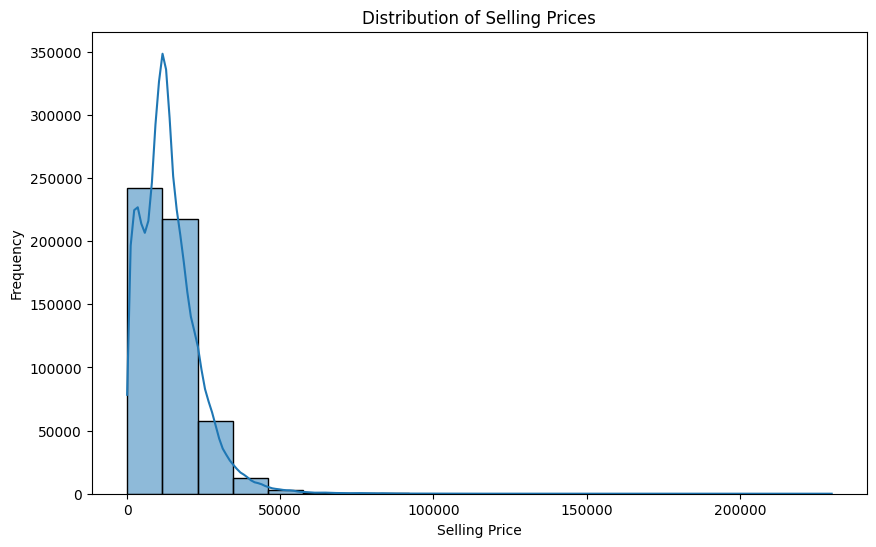

In [11]:
 #Plot the distribution of selling prices
plt.figure(figsize=(10, 6))
sns.histplot(df['sellingprice'], bins=20, kde=True)
plt.title('Distribution of Selling Prices')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

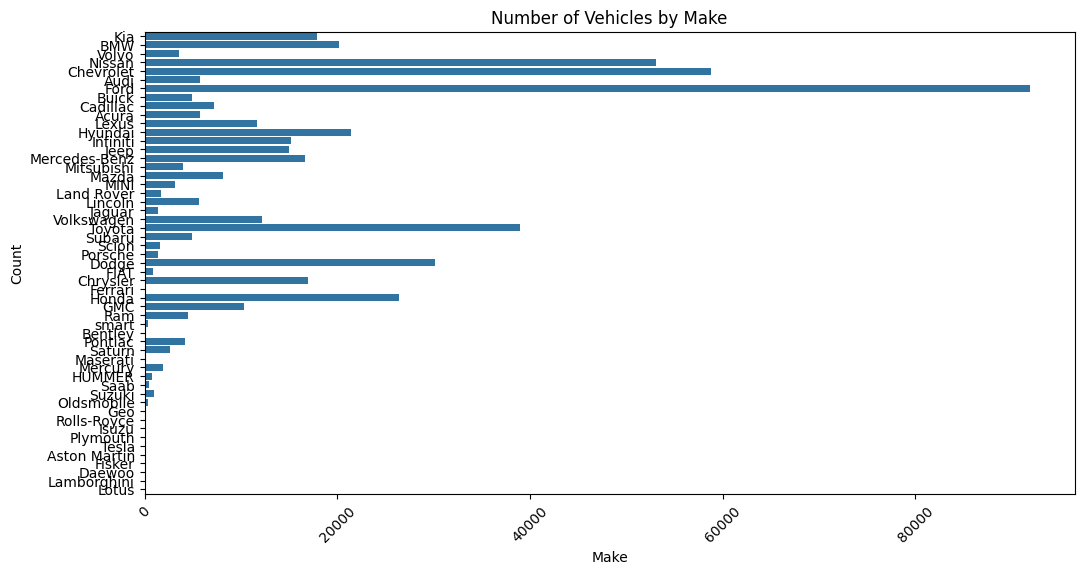

In [ ]:
# Plot the number of vehicles by make
plt.figure(figsize=(12, 6))
sns.countplot(df['make'])
plt.title('Number of Vehicles by Make')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

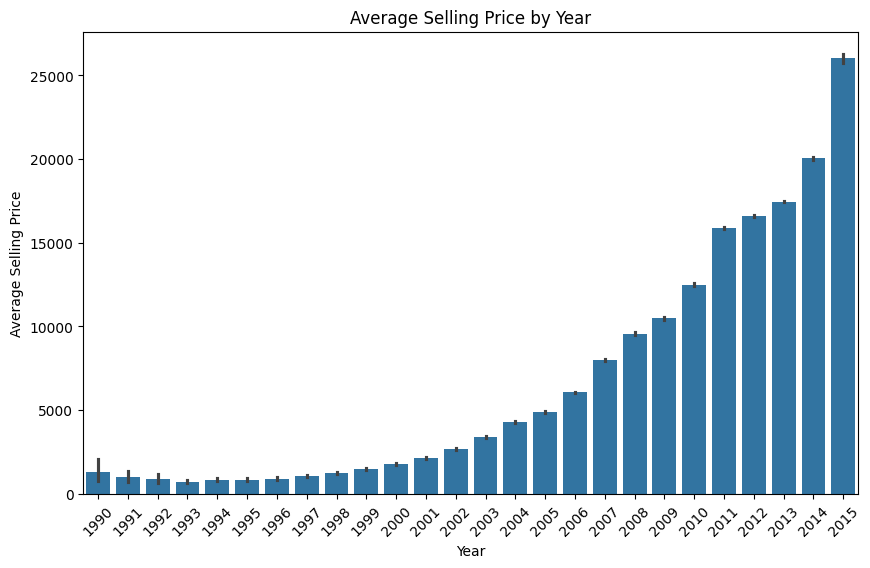

In [12]:
# Plot the average selling price by year
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='sellingprice', data=df)
plt.title('Average Selling Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Selling Price')
plt.xticks(rotation=45)
plt.show()

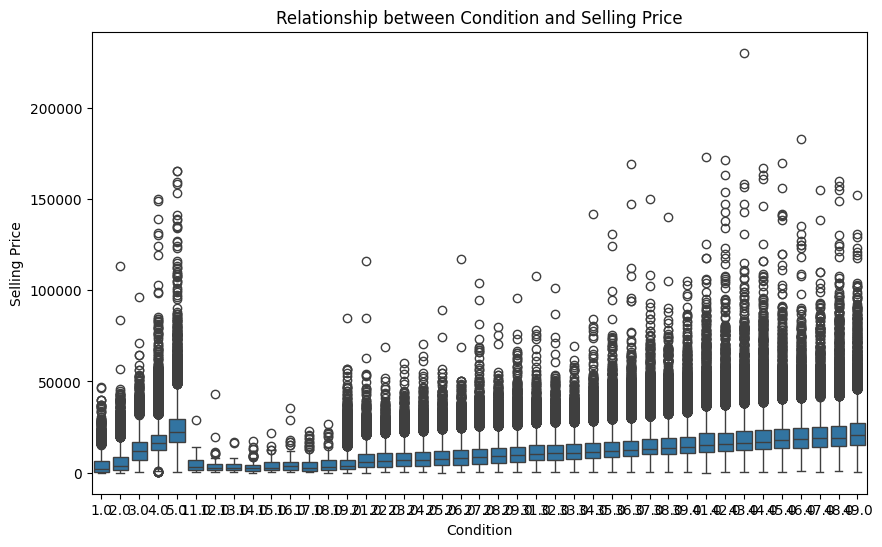

In [ ]:
# Plot the relationship between condition and selling price
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='sellingprice', data=df)
plt.title('Relationship between Condition and Selling Price')
plt.xlabel('Condition')
plt.ylabel('Selling Price')
plt.show()

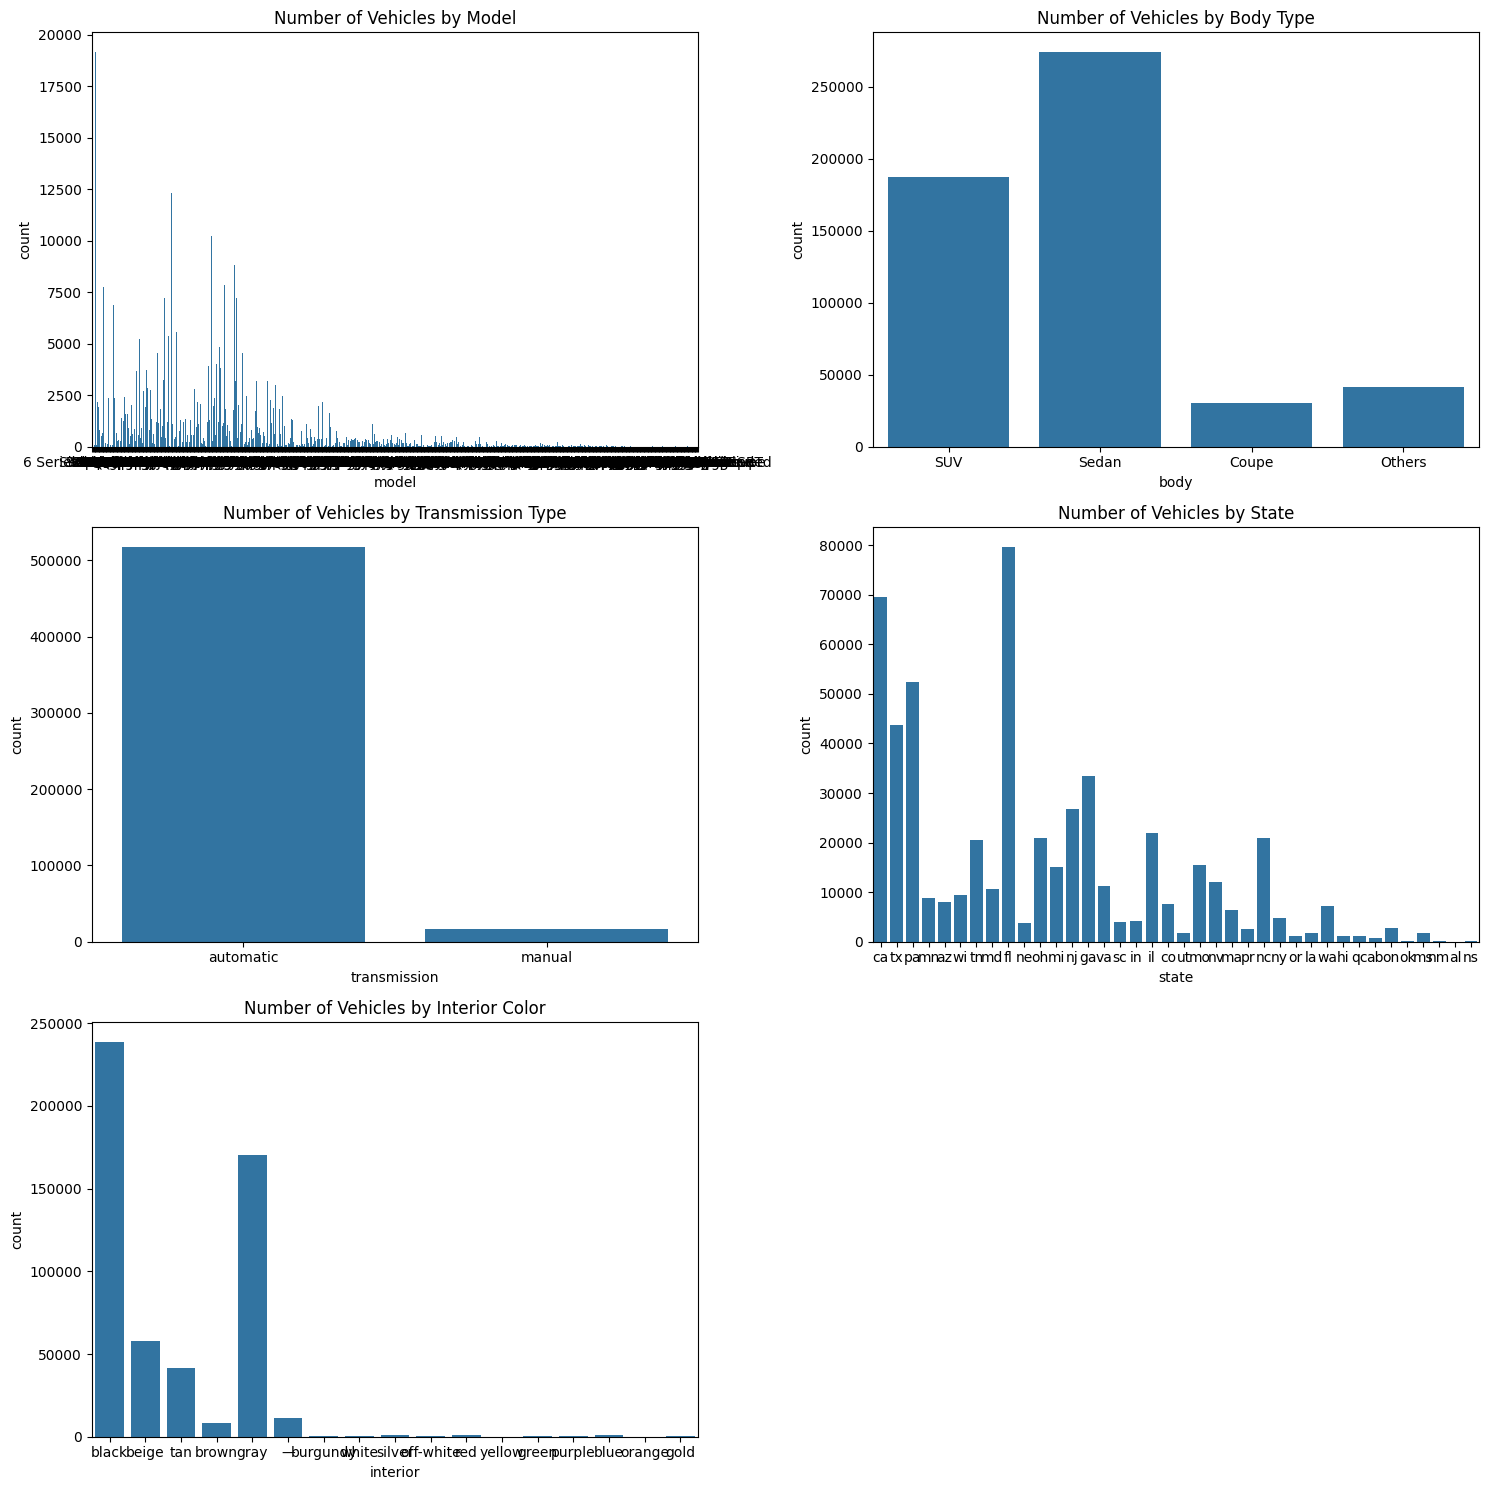

In [ ]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Plot the number of vehicles by model
sns.countplot(x='model', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Number of Vehicles by Model')

# Plot the number of vehicles by body type
sns.countplot(x='body', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Number of Vehicles by Body Type')

# Plot the number of vehicles by transmission type
sns.countplot(x='transmission', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Number of Vehicles by Transmission Type')

# Plot the number of vehicles by state
sns.countplot(x='state', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Number of Vehicles by State')

# Plot the number of vehicles by interior color
sns.countplot(x='interior', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Number of Vehicles by Interior Color')

# Hide the empty subplot
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [13]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


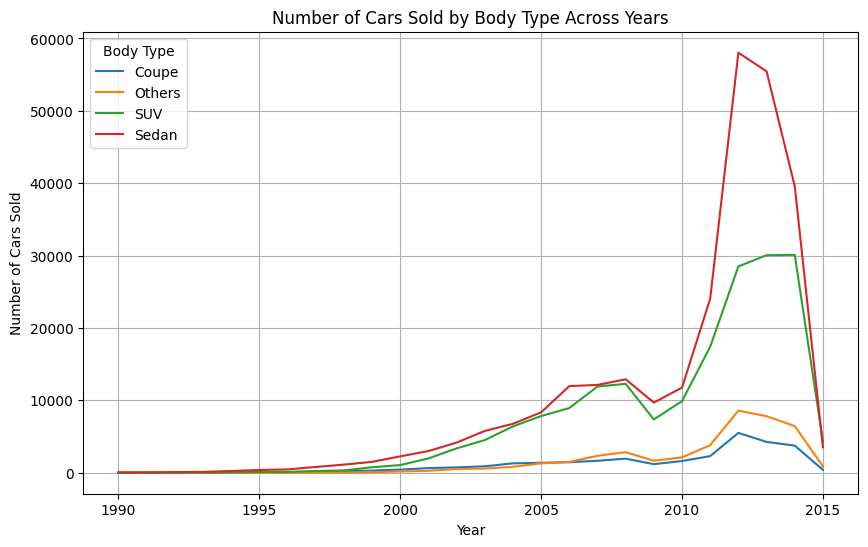

In [14]:
# Group by 'year' and 'body' and count the number of cars sold
sales_by_body_year = df.groupby(['year', 'body']).size().unstack(fill_value=0)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_by_body_year, dashes=False)
plt.title('Number of Cars Sold by Body Type Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Cars Sold')
plt.legend(title='Body Type', loc='upper left')
plt.grid(True)
plt.show()

In [40]:
sales_by_body_year = df.groupby(['year', 'body']).size().unstack(fill_value=0)
sales_by_body_year

body,Coupe,Others,SUV,Sedan
year,,,,
1990,5,6,2,27
1991,13,4,1,39
1992,16,0,12,83
1993,15,0,24,116
1994,36,8,43,237
1995,75,19,99,379
1996,72,9,118,457
1997,169,7,231,793
1998,205,31,318,1119


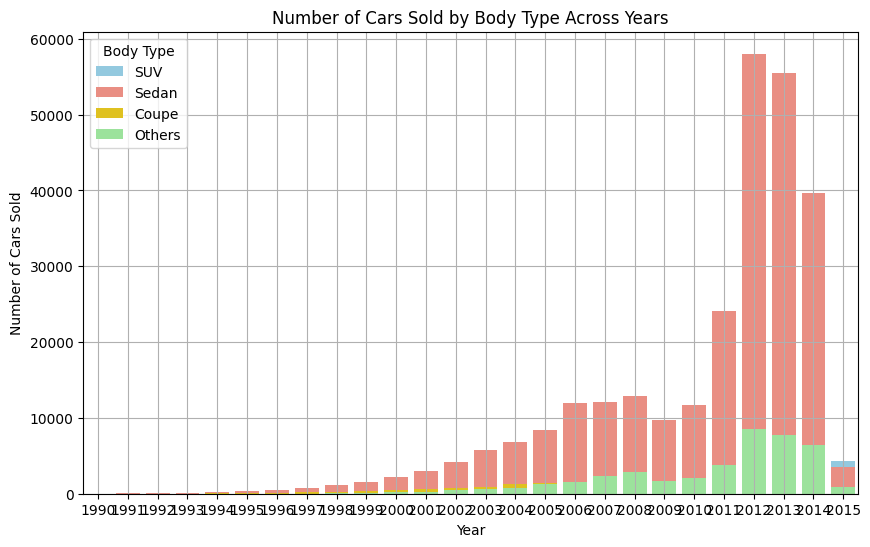

In [15]:
# Plot using seaborn
plt.figure(figsize=(10, 6))

# Plot for SUV
sns.barplot(data=sales_by_body_year.reset_index(), x='year', y='SUV', color='skyblue', label='SUV')

# Plot for Sedan
sns.barplot(data=sales_by_body_year.reset_index(), x='year', y='Sedan', color='salmon', label='Sedan')

# Plot for Coupe
sns.barplot(data=sales_by_body_year.reset_index(), x='year', y='Coupe', color='gold', label='Coupe')

# Plot for Others
sns.barplot(data=sales_by_body_year.reset_index(), x='year', y='Others', color='lightgreen', label='Others')

plt.title('Number of Cars Sold by Body Type Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Cars Sold')
plt.legend(title='Body Type', loc='upper left')
plt.grid(True)
plt.show()

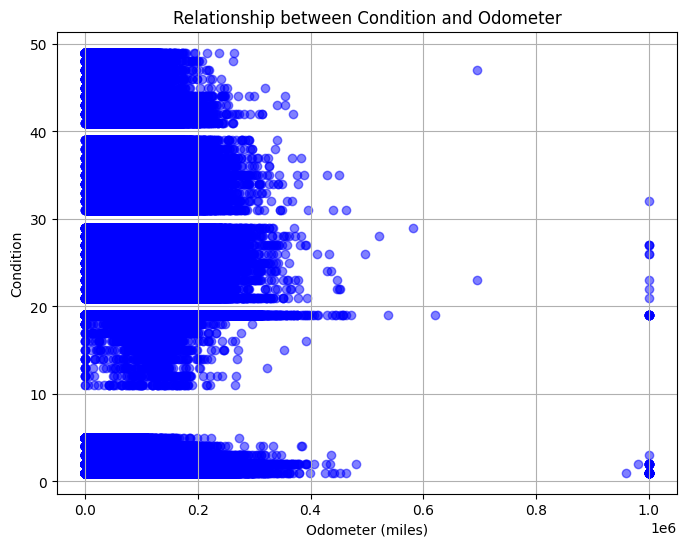

In [16]:
# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['odometer'], df['condition'], color='blue', alpha=0.5)
plt.title('Relationship between Condition and Odometer')
plt.ylabel('Condition')
plt.xlabel('Odometer (miles)')
plt.grid(True)
plt.show()

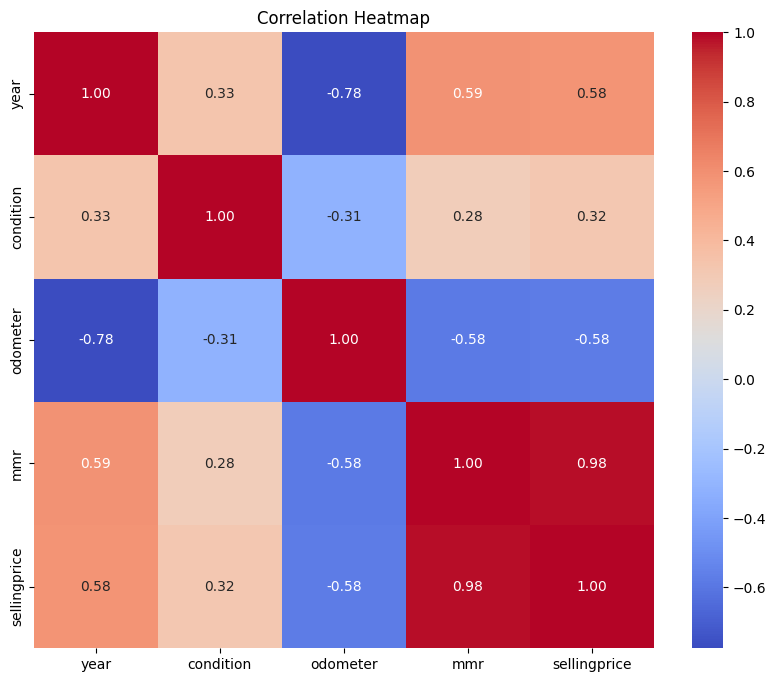

In [17]:
corr_matrix = df[['year','condition','odometer','mmr','sellingprice']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1000x800 with 0 Axes>

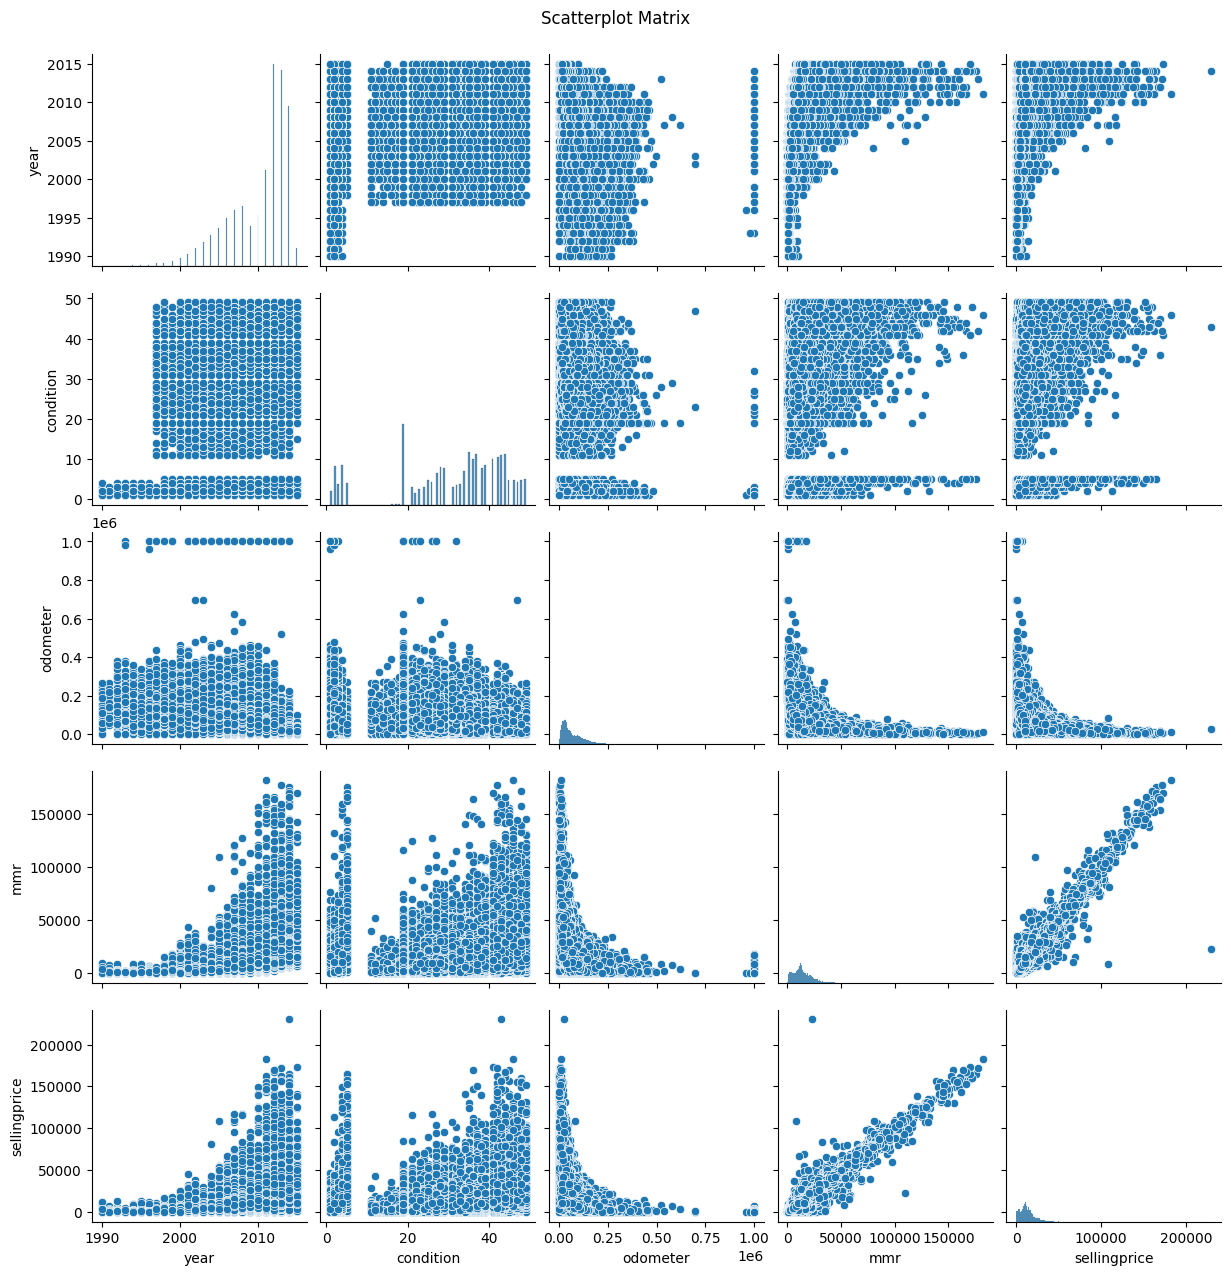

In [18]:
# Select only numerical columns
numerical_df = df[['year','condition','odometer','mmr','sellingprice']]

# Plot scatterplot matrix (pairplot)
plt.figure(figsize=(10, 8))
sns.pairplot(numerical_df)
plt.suptitle('Scatterplot Matrix', y=1.02)
plt.show()

<Figure size 1000x600 with 0 Axes>

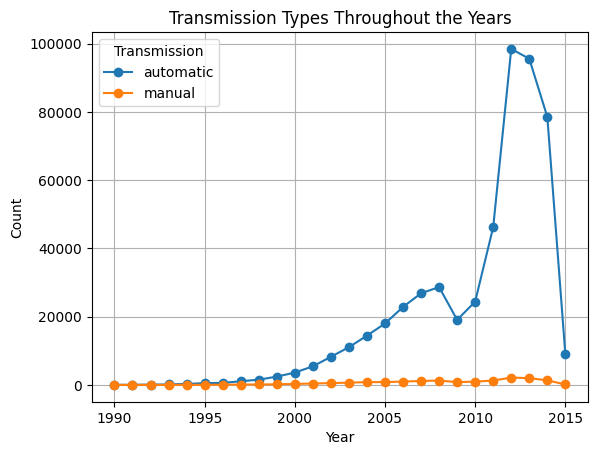

In [19]:
transmission_counts = df.groupby(['year', 'transmission']).size().unstack(fill_value=0)

# Plot line plot for transmission types throughout the years
plt.figure(figsize=(10, 6))
transmission_counts.plot(kind='line', marker='o')
plt.title('Transmission Types Throughout the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Transmission')
plt.grid(True)
plt.show()

In [39]:
transmission_counts = df.groupby(['year', 'transmission']).size().unstack(fill_value=0)
transmission_counts

transmission,automatic,manual
year,,
1990,32,8
1991,52,5
1992,101,10
1993,139,16
1994,287,37
1995,526,46
1996,587,69
1997,1084,116
1998,1541,132


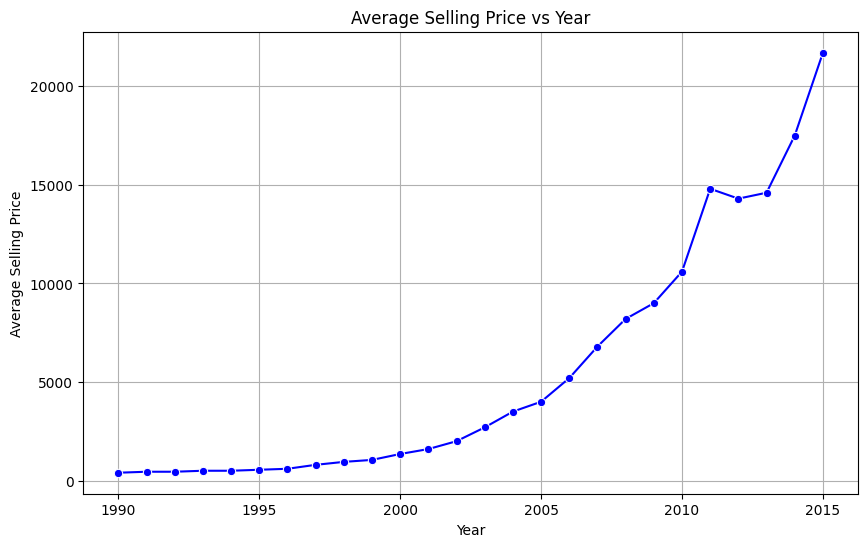

In [20]:
# Calculate average selling price for each year
average_selling_price = df.groupby('year')['sellingprice'].median().reset_index()

# Plot line plot for average selling price vs year
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_selling_price, x='year', y='sellingprice', marker='o', color='blue')
plt.title('Average Selling Price vs Year')
plt.xlabel('Year')
plt.ylabel('Average Selling Price')
plt.grid(True)
plt.show()

In [41]:
average_selling_price = df.groupby('year')['sellingprice'].median().reset_index()
average_selling_price

,year,sellingprice
0,1990,400.0
1,1991,450.0
2,1992,450.0
3,1993,500.0
4,1994,500.0
5,1995,550.0
6,1996,600.0
7,1997,800.0
8,1998,950.0
9,1999,1050.0


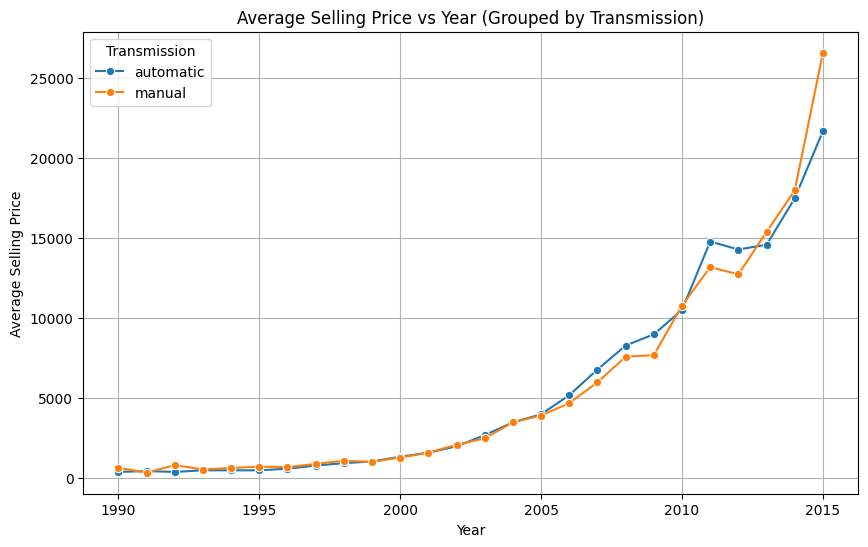

In [21]:
# Calculate average selling price for each year and transmission type
average_selling_price = df.groupby(['year', 'transmission'])['sellingprice'].median().reset_index()

# Plot line plot for average selling price vs year grouped by transmission
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_selling_price, x='year', y='sellingprice', hue='transmission', marker='o')
plt.title('Average Selling Price vs Year (Grouped by Transmission)')
plt.xlabel('Year')
plt.ylabel('Average Selling Price')
plt.grid(True)
plt.legend(title='Transmission')
plt.show()

In [42]:
average_selling_price = df.groupby(['year', 'transmission'])['sellingprice'].median().reset_index()
average_selling_price

,year,transmission,sellingprice
0,1990,automatic,400.0
1,1990,manual,662.5
2,1991,automatic,450.0
3,1991,manual,350.0
4,1992,automatic,400.0
5,1992,manual,825.0
6,1993,automatic,500.0
7,1993,manual,550.0
8,1994,automatic,500.0
9,1994,manual,650.0


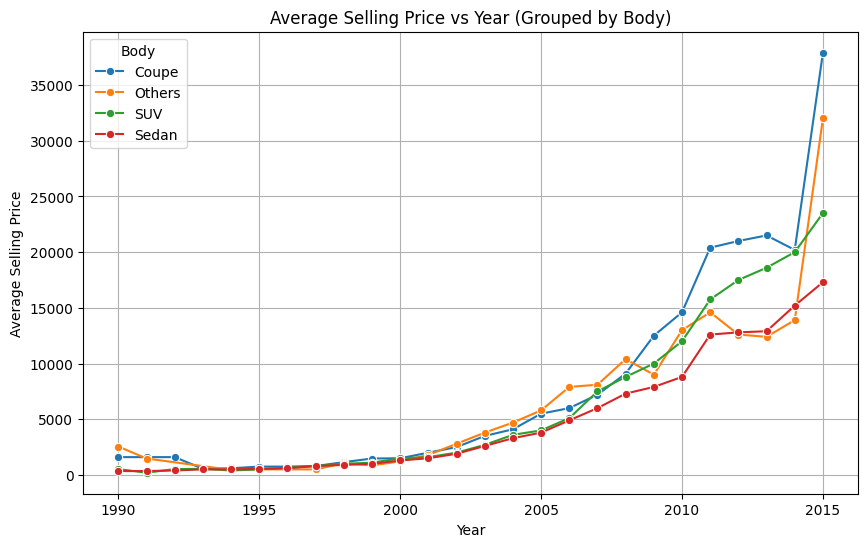

In [22]:
# Calculate average selling price for each year and transmission type
average_selling_price = df.groupby(['year', 'body'])['sellingprice'].median().reset_index()

# Plot line plot for average selling price vs year grouped by transmission
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_selling_price, x='year', y='sellingprice', hue='body', marker='o')
plt.title('Average Selling Price vs Year (Grouped by Body)')
plt.xlabel('Year')
plt.ylabel('Average Selling Price')
plt.grid(True)
plt.legend(title='Body')
plt.show()

In [43]:
average_selling_price = df.groupby(['year', 'body'])['sellingprice'].median().reset_index()
average_selling_price

,year,body,sellingprice
0,1990,Coupe,1600.0
1,1990,Others,2550.0
2,1990,SUV,525.0
3,1990,Sedan,350.0
4,1991,Coupe,1600.0
...,...,...,...
97,2014,Sedan,15200.0
98,2015,Coupe,37900.0
99,2015,Others,32000.0
100,2015,SUV,23500.0


In [23]:
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


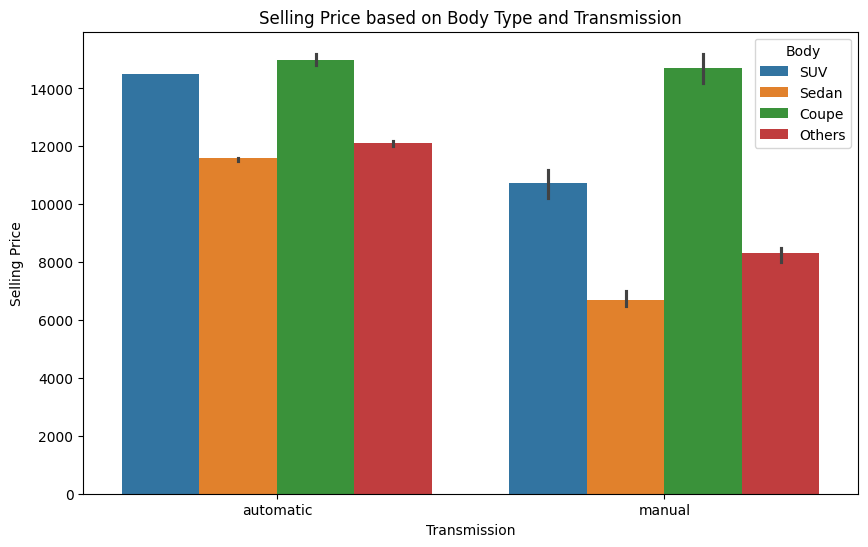

In [37]:
# Plot the effect of body and transmission on selling price
plt.figure(figsize=(10, 6))
sns.barplot(x='transmission', y='sellingprice', hue='body', data=df,estimator=np.median)
plt.title('Selling Price based on Body Type and Transmission')
plt.xlabel('Transmission')
plt.ylabel('Selling Price')
plt.legend(title='Body')
plt.show()

In [51]:
df.groupby(['transmission', 'body'])['sellingprice'].median().reset_index()

,transmission,body,sellingprice
0,automatic,Coupe,15000.0
1,automatic,Others,12100.0
2,automatic,SUV,14500.0
3,automatic,Sedan,11600.0
4,manual,Coupe,14700.0
5,manual,Others,8300.0
6,manual,SUV,10750.0
7,manual,Sedan,6700.0


In [ ]:
df[df['body']=='Coupe'][df['transmission']=='automatic']['sellingprice'].median()

<ipython-input-37-549eb25d8919>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['body']=='Coupe'][df['transmission']=='automatic']['sellingprice'].median()


15000.0

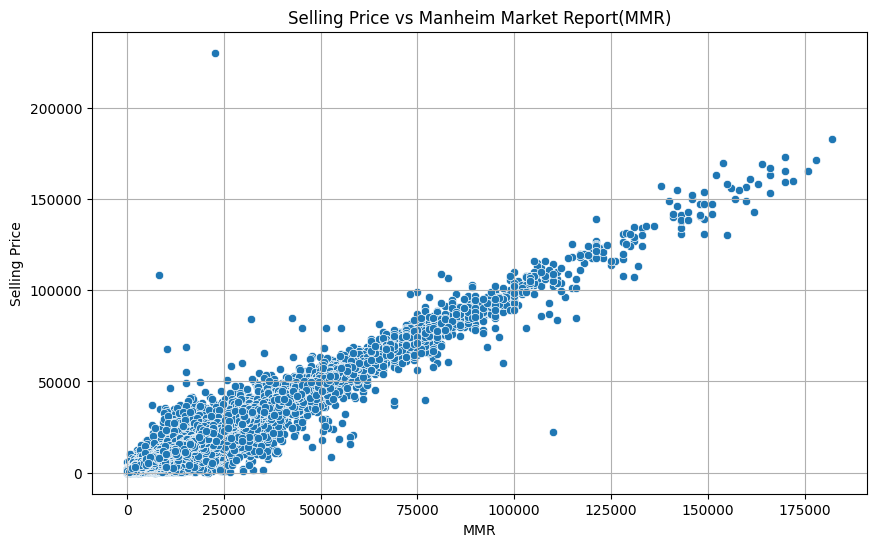

In [25]:
# Plot line plot for average selling price vs year grouped by transmission
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='mmr', y='sellingprice', marker='o')
plt.title('Selling Price vs Manheim Market Report(MMR)')
plt.xlabel('MMR')
plt.ylabel('Selling Price')
plt.grid(True)
plt.show()

In [52]:
continent_mapping = {
    'Asia': ['Kia', 'Nissan', 'Acura', 'Lexus', 'Hyundai', 'Infiniti', 'Mitsubishi', 'Mazda', 'Toyota', 'Subaru', 'Scion', 'Honda', 'Suzuki', 'Isuzu', 'Daewoo'],
    'Europe': ['BMW', 'Volvo', 'Audi', 'Mercedes-Benz', 'MINI', 'Land Rover', 'Jaguar', 'Volkswagen', 'Porsche', 'FIAT', 'Ferrari', 'smart', 'Bentley', 'Rolls-Royce', 'Maserati', 'Saab', 'Tesla', 'Aston Martin', 'Lamborghini', 'Lotus'],
    'North America': ['Chevrolet', 'Ford', 'Buick', 'Cadillac', 'Jeep', 'Lincoln', 'Dodge', 'Chrysler', 'GMC', 'Ram', 'Pontiac', 'Saturn', 'Mercury', 'HUMMER', 'Plymouth', 'Fisker', 'Oldsmobile', 'Geo']
}

In [53]:
# Create a function to map car makes to continents
def map_to_continent(make):
    for continent, makes in continent_mapping.items():
        if make in makes:
            return continent
    return 'Other'

# Apply the mapping function to create a new column 'continent'
df['cont'] = df['make'].apply(map_to_continent)

In [54]:
df['cont'].value_counts()

cont
North America    255354
Asia             210358
Europe            67936
Name: count, dtype: int64

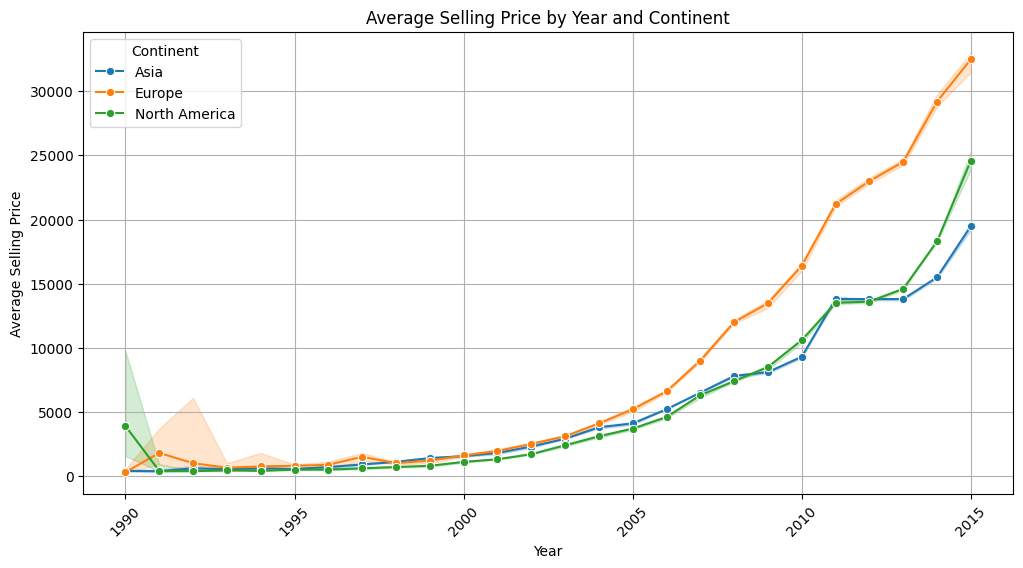

In [31]:
# Plot the average selling price by year and continent
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sellingprice', hue='cont', data=df,estimator=np.median,marker='o')
plt.title('Average Selling Price by Year and Continent')
plt.xlabel('Year')
plt.ylabel('Average Selling Price')
plt.legend(title='Continent')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [55]:
df.groupby(['year', 'cont'])['sellingprice'].median().reset_index()

,year,cont,sellingprice
0,1990,Asia,400.0
1,1990,Europe,300.0
2,1990,North America,3900.0
3,1991,Asia,375.0
4,1991,Europe,1800.0
...,...,...,...
73,2014,Europe,29200.0
74,2014,North America,18300.0
75,2015,Asia,19500.0
76,2015,Europe,32500.0


In [32]:
df['cont'].value_counts()

cont
North America    255354
Asia             210358
Europe            67936
Name: count, dtype: int64

In [33]:
df[df['cont']=='Europe']['make'].value_counts()

make
BMW              20140
Mercedes-Benz    16631
Volkswagen       12171
Audi              5720
Volvo             3628
MINI              3167
Land Rover        1708
Jaguar            1377
Porsche           1361
FIAT               857
Saab               453
smart              389
Maserati           131
Bentley            115
Aston Martin        25
Tesla               23
Ferrari             19
Rolls-Royce         16
Lamborghini          4
Lotus                1
Name: count, dtype: int64

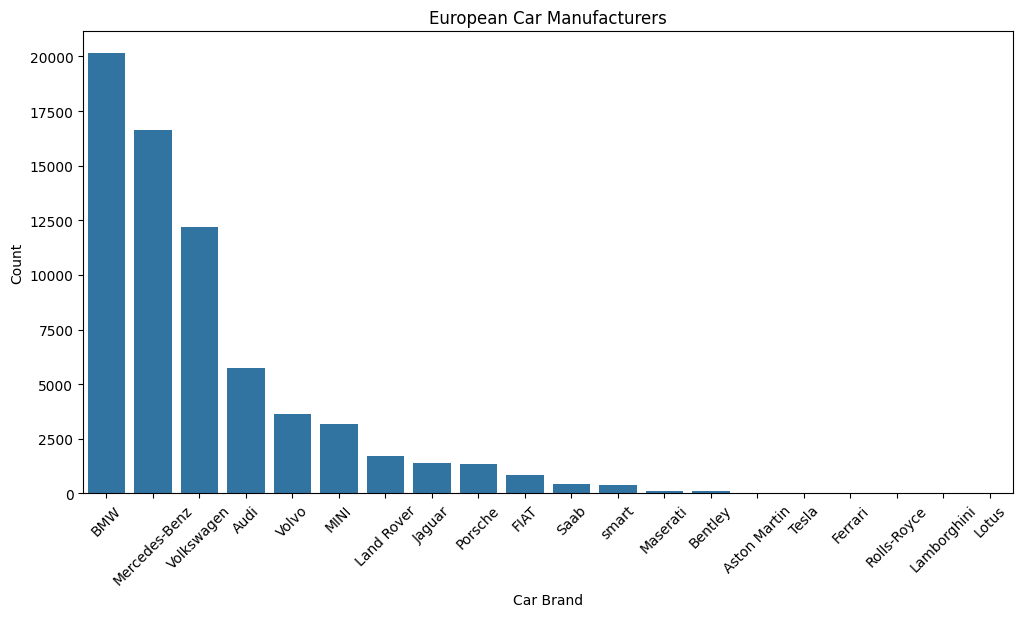

In [56]:
# Filter the DataFrame to include only car makes from Europe
europe_makes = df[df['cont'] == 'Europe']['make']

# Plot the count of car makes from Europe
plt.figure(figsize=(12, 6))
sns.countplot(x=europe_makes, order=europe_makes.value_counts().index)
plt.title('European Car Manufacturers')
plt.xlabel('Car Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

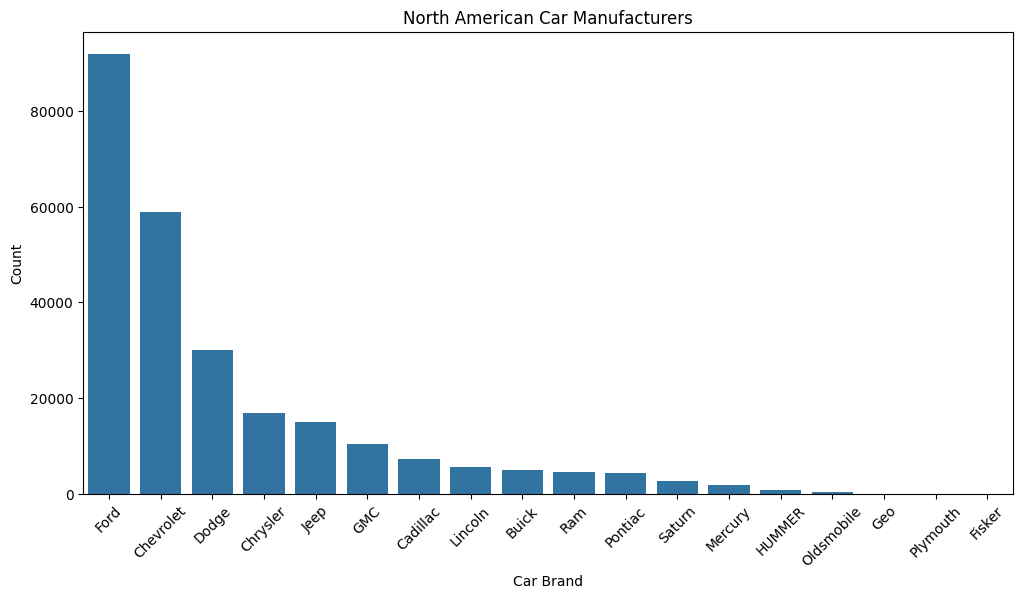

In [57]:
# Filter the DataFrame to include only car makes from Europe
na_makes = df[df['cont'] == 'North America']['make']

# Plot the count of car makes from Europe
plt.figure(figsize=(12, 6))
sns.countplot(x=na_makes, order=na_makes.value_counts().index)
plt.title('North American Car Manufacturers')
plt.xlabel('Car Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

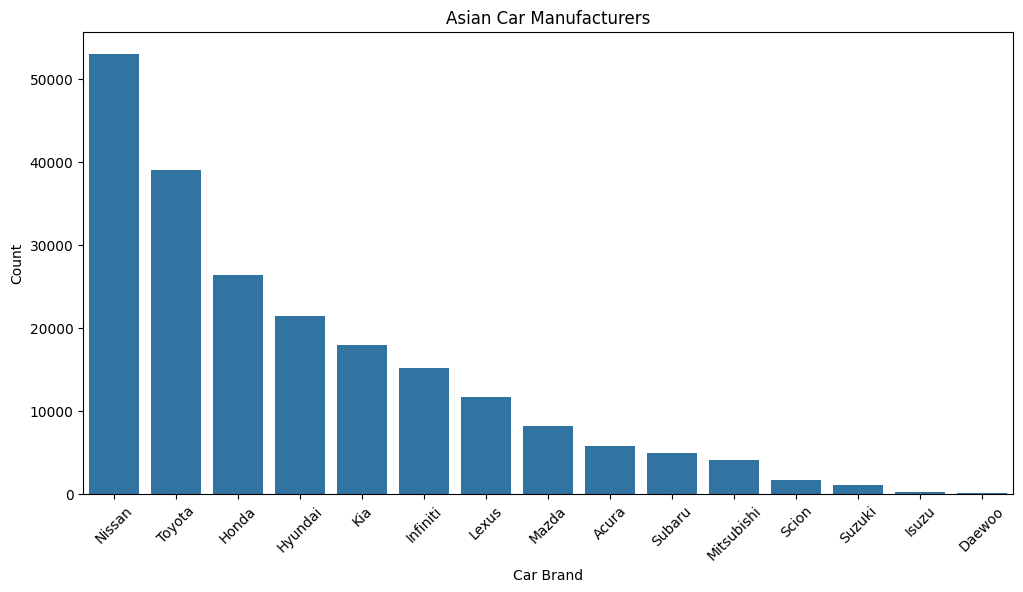

In [58]:
# Filter the DataFrame to include only car makes from Europe
asia_makes = df[df['cont'] == 'Asia']['make']

# Plot the count of car makes from Europe
plt.figure(figsize=(12, 6))
sns.countplot(x=asia_makes, order=asia_makes.value_counts().index)
plt.title('Asian Car Manufacturers')
plt.xlabel('Car Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [62]:
print("European: ", europe_makes.value_counts())
print("North American: ",na_makes.value_counts())
print("Asian: ",asia_makes.value_counts())

European:  make
BMW              20140
Mercedes-Benz    16631
Volkswagen       12171
Audi              5720
Volvo             3628
MINI              3167
Land Rover        1708
Jaguar            1377
Porsche           1361
FIAT               857
Saab               453
smart              389
Maserati           131
Bentley            115
Aston Martin        25
Tesla               23
Ferrari             19
Rolls-Royce         16
Lamborghini          4
Lotus                1
Name: count, dtype: int64
North American:  make
Ford          91907
Chevrolet     58817
Dodge         30100
Chrysler      16914
Jeep          15013
GMC           10317
Cadillac       7250
Lincoln        5611
Buick          4928
Ram            4545
Pontiac        4244
Saturn         2656
Mercury        1889
HUMMER          786
Oldsmobile      333
Geo              19
Plymouth         16
Fisker            9
Name: count, dtype: int64
Asian:  make
Nissan        53085
Toyota        38991
Honda         26373
Hyundai       214

In [ ]:
corr_matrix

,year,condition,odometer,mmr,sellingprice
year,1.000000,0.332918,-0.775187,0.588987,0.579093
condition,0.332918,1.000000,-0.313025,0.275288,0.316452
odometer,-0.775187,-0.313025,1.000000,-0.581737,-0.576545
mmr,0.588987,0.275288,-0.581737,1.000000,0.983677
sellingprice,0.579093,0.316452,-0.576545,0.983677,1.000000
